Initializing Julia

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


Downloading *Distributions*

In [ ]:
import Pkg; Pkg.add("Distributions")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed StatsFuns ──────── v0.9.15
   Installed OpenSpecFun_jll ── v0.5.5+0
   Installed Rmath ──────────── v0.7.0
   Installed Rmath_jll ──────── v0.3.0+0
   Installed QuadGK ─────────── v2.4.2
   Installed FillArrays ─────── v0.12.7
   Installed SpecialFunctions ─ v2.0.0
   Installed Distributions ──── v0.25.41
   Installed DensityInterface ─ v0.4.0
   Installed PDMats ─────────── v0.11.5
    Updating `~/.julia/environments/v1.6/Project.toml`
  [31c24e10] + Distributions v0.25.41
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [b429d917] + DensityInterface v0.4.0
  [31c24e10] + Distributions v0.25.41
  [1a297f60] + FillArrays v0.12.7
  [90014a1f] + PDMats v0.11.5
  [1fd47b50] + QuadGK v2.4.2
  [79098fc4] + Rmath v0.7.0
  [276daf66] + SpecialFunctions v2.0.0
  [4c63d2b9] + StatsFuns v0.9.15
  [efe28fd5] + OpenSpecFun_jll v0.5.5+0
  [f50d1b31] + Rmath_jll v0.3.0+0
  [4607b0f0] + Suite

# **Why Population based methods?**
When we talk about population based methods we mean that, instead of working with a single design point to minimze a function we use multiple candidates called as Individuals in GA(Genetic Algorithim).

This type of method benifits in finding new solutions. Since Different candidates can contribute jointly to finding an optimal solution.


# **Why Choose the Rastingin Function?**
The Reason for choosing this function is beacuse in real life we wont be dealing with smooth functions.
In fact the terrain will be Jagged.
Populations methods in such scenarios are robust because they have the ability to get out of a local minimum and usually converge at an global minimum.




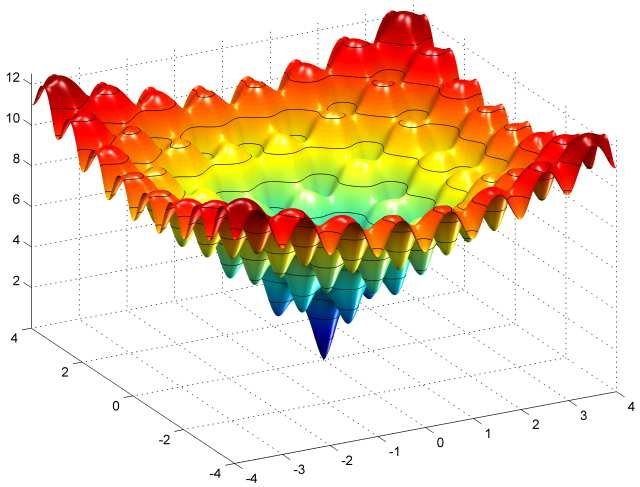

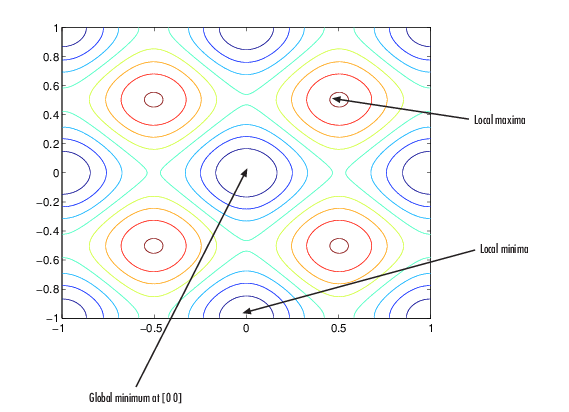

Initalizing a distrubution:
Whenever people think of distributions people think of a gaussian distribution

But the tails of a cauchy distribution do not taper off as quickly as a normal distribution.

It is a family of continuous probably distributions which resemble the normal distribution family of curves. While the resemblance is there, it has a taller peak than a normal. And unlike the normal distribution, it’s fat tails decay much more slowly


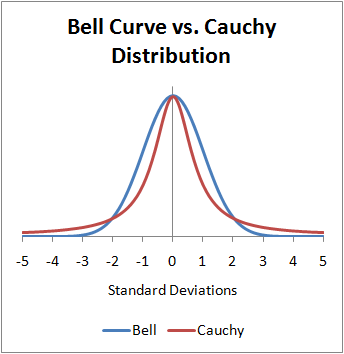

# **Why use the cauchy Distribution?**
The cachy Distribution accounts for higher probablity of extreme events occouring.

The Cauchy distribution is heavy tailed, allowing it to cover the design space more broadly.

In [ ]:
using Distributions
function rand_population_cauchy(m, μ, σ)
n = length(μ)
return [[rand(Cauchy(μ[j],σ[j])) for j in 1:n] for i in 1:m]
end

rand_population_cauchy (generic function with 1 method)

Defining the genetic algorithim function

In [ ]:
function genetic_algorithm(f, population, k_max, S, C, M)
for k in 1 : k_max
parents = select(S, f.(population))
children = [crossover(C,population[p[1]],population[p[2]])
for p in parents]
population .= mutate.(Ref(M), children)
end
population[argmin(f.(population))]
end

genetic_algorithm (generic function with 1 method)

What & Why Turnication Selection?

Turnication Selection is one on of the siplest metheds for selecting parents in GA.

this is beacuse the method selects the best "k" individuals from the poulation that minimize the objective function ;Since we are dealing with a minimization problem.



In [ ]:
abstract type SelectionMethod end
struct TruncationSelection <: SelectionMethod
k # top k to keep
end
function select(t::TruncationSelection, y)
p = sortperm(y)
return [p[rand(1:t.k, 2)] for i in y]
end

select (generic function with 1 method)

Single Point CrossOver:
A crossover point on the parent organism string is selected. All data beyond that point in the organism string is swapped between the two parent organisms


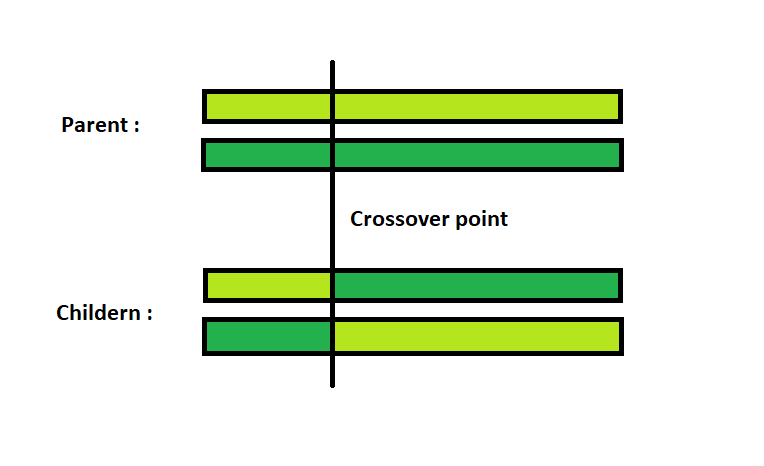


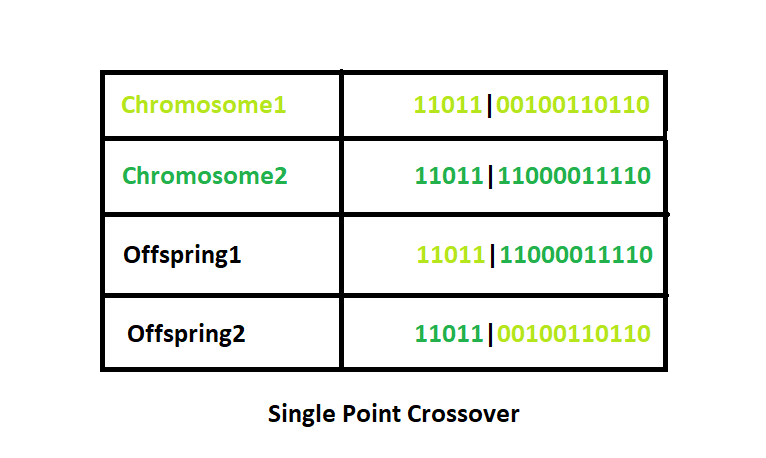


In [ ]:
abstract type CrossoverMethod end
struct SinglePointCrossover <: CrossoverMethod end
function crossover(::SinglePointCrossover, a, b)
i = rand(1:length(a))
return vcat(a[1:i], b[i+1:end])
end

crossover (generic function with 1 method)

Gaussian Mutation:

Gaussian mutation consists in adding a random value from a Gaussian distribution to each element of an individual’s vector to create a new offspring

Gaussian Mutation makes use of the Gauss error function

In [ ]:
abstract type MutationMethod end
struct GaussianMutation <: MutationMethod
σ
end
function mutate(M::GaussianMutation, child)
return child + randn(length(child))*M.σ
end

mutate (generic function with 1 method)

Running the Genetic Alogrithim and defining Hyperparameters:

In [ ]:
f = x-> 10length(x) + sum(x.^2 .- 10 .* cos.(2π .* x))
m = 100 # population size
k_max = 20 # number of iterations
population = rand_population_cauchy(m, [-3, 3], [3,3])
S = TruncationSelection(10) # select top 10
C = SinglePointCrossover()
M = GaussianMutation(0.5) # mutation rate
x = genetic_algorithm(f, population, k_max, S, C, M)
@show x

x = [0.006419421634629441, 0.011556633027640983]


2-element Vector{Float64}:
 0.006419421634629441
 0.011556633027640983

After running the algoritm we can see that the function is close to the minimum
Actually its allmost Bang On!